# How to add persistence ("memory") to your graph

Many AI applications need memory to share context across multiple interactions. In LangGraph, memory is provided for any [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph) through [Checkpointers](https://github.com/langchain-ai/langgraph/tree/e4ca7ab69c599fd77dd4f0d47280849d715392cc/libs/checkpoint).

When creating any LangGraph workflow, you can set them up to persist their state by doing using the following:

1. A [Checkpointer](https://langchain-ai.github.io/langgraph/reference/checkpoints/#basecheckpointsaver), such as the [AsyncSqliteSaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#asyncsqlitesaver)
2. Call `compile(checkpointer=my_checkpointer)` when compiling the graph.

Example:
```python
from langgraph.graph import StateGraph
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

builder = StateGraph(....)
# ... define the graph
memory = AsyncSqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)
...
```

This works for [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph) and all its subclasses, such as [MessageGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#messagegraph).

Below is an example.

<div class="admonition tip">
    <p class="admonition-title">Note</p>
    <p>
        In this how-to, we will create our agent from scratch to be transparent (but verbose). You can accomplish similar functionality using the <code>create_react_agent(model, tools=tool, checkpointer=checkpointer)</code> (<a href="https://langchain-ai.github.io/langgraph/reference/prebuilt/#create_react_agent">API doc</a>) constructor. This may be more appropriate if you are used to LangChain’s <a href="https://python.langchain.com/v0.2/docs/how_to/agent_executor/#concepts">AgentExecutor</a> class.
    </p>
</div>    

## Setup

First we need to install the packages required

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [21]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [22]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

## Set up the State

The state is the interface for all the nodes.

In [37]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

# Add messages essentially does this with more
# robust handling
# def add_messages(left: list, right: list):
#     return left + right


class State(TypedDict):
    messages: Annotated[list, add_messages]

## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use create a placeholder search engine.
However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/v0.2/docs/how_to/custom_tools) on how to do that.


In [24]:
from langchain_core.tools import tool


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    return ["The answer to your question lies within."]


tools = [search]

Now we can create our [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tool+node#toolnode). This 
object actually **runs** the tools (aka functions)  that the LLM has asked to use.

In [25]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

## Set up the model

Now we need to load the [chat model](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to power our agent.
For the design below, it must satisfy two criteria:

1. It should work with **messages** (since our state contains a list of chat messages)
2. It should work with [**tool calling**](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling).

<div class="admonition tip">
    <p class="admonition-title">Note</p>
    <p>
        These model requirements are not general requirements for using LangGraph - they are just requirements for this one example.
    </p>
</div>    
    

In [26]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this by converting the LangChain tools into the format for OpenAI function calling, and then bind them to the model class.


In [27]:
bound_model = model.bind_tools(tools)

## Define the graph 

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

In [28]:
# Define the function that determines whether to continue or not
from typing import Literal


def should_continue(state: State) -> Literal["action", "__end__"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "__end__"
    # Otherwise if there is, we continue
    return "action"


# Define the function that calls the model
def call_model(state: State):
    response = model.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": response}

We can now put it all together and define the graph!

In [29]:
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

**Persistence**

To add in persistence, we pass in a checkpoint when compiling the graph

In [30]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [31]:
# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)

<div class="admonition tip">
    <p class="admonition-title">Note</p>
    <p>
        If you're using LangGraph Cloud, you <strong>don't need</strong> to pass checkpointer when compiling the graph, since it's done automatically.
    </p>
</div>

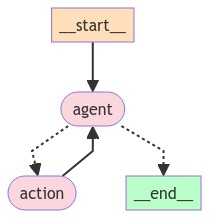

In [32]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Interacting with the Agent

We can now interact with the agent and see that it remembers previous messages!


In [33]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="hi! I'm bob")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

Hello Bob! How can I assist you today?


In [34]:
input_message = HumanMessage(content="what is my name?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

Your name is Bob.


If we want to start a new conversation, we can pass in a different thread id. Poof! All the memories are gone!

In [35]:
input_message = HumanMessage(content="what is my name?")
for event in app.stream(
    {"messages": [input_message]},
    {"configurable": {"thread_id": "3"}},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

I'm sorry, I do not know your name as I am an AI assistant and do not have access to personal information.


All the checkpoints are persisted to the checkpointer, so you can always resume previous threads.

In [36]:
input_message = HumanMessage(content="You forgot??")
for event in app.stream(
    {"messages": [input_message]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

You forgot??
================================== Ai Message ==================================

I apologize for the confusion. I am an AI assistant and I do not have the ability to remember information from previous interactions. How can I assist you today, Bob?
